In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [2]:
TEST = True

random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [3]:
fft_train_file = "dataset/processed_data/torso_train_fft.npy"
fft_val_file = "dataset/processed_data/torso_val_fft.npy"
fft_test_file = "dataset/processed_data/torso_test_fft.npy"

label_train_file = "dataset/processed_data/torso_train_label.npy"
label_val_file = "dataset/processed_data/torso_val_label.npy"
label_test_file = "dataset/processed_data/torso_test_label.npy"

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, label, normalize=False):
        super().__init__()
        self.data = data.astype(np.float32)
        self.label = label

        assert len(self.data) == len(self.label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [16]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class DataModule(L.LightningDataModule):
    def __init__(self, batch_size = 1024):
        super().__init__()
        self.save_hyperparameters()
        
    def setup(self, stage=None):
        fft_train_data = np.load(fft_train_file)
        label_train_data = np.load(label_train_file)

        fft_val_data = np.load(fft_val_file)
        label_val_data = np.load(label_val_file)

        fft_test_data = np.load(fft_test_file)
        label_test_data = np.load(label_test_file)

        self.train_set = CustomDataset(fft_train_data, label_train_data)
        self.val_set = CustomDataset(fft_val_data, label_val_data)
        self.test_set = CustomDataset(fft_test_data, label_test_data)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_set, batch_size=self.hparams.batch_size, shuffle=True, pin_memory=True)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_set, batch_size=self.hparams.batch_size, shuffle=False, pin_memory=True)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test_set, batch_size=self.hparams.batch_size, shuffle=False, pin_memory=True)
    
        

In [17]:
if TEST:
    data_module = DataModule()
    data_module.setup()

In [18]:
if TEST:
    print(len(data_module.train_set))
    print(len(data_module.val_set))
    print(len(data_module.test_set))

In [19]:
if TEST:
    val_loader = data_module.val_dataloader()
    print(next(iter(val_loader)))

In [20]:
learning_rate = 0.01
momentum = 0.5


In [29]:
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler

class Net(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.rand(10, 6, 8, 257)

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=32, kernel_size=(1, 8), padding=(0, 0), stride=(1, 3)),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 8), padding=(0, 0), stride=(1, 3)),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(8, 1), padding=(0, 0), stride=(1, 1)),
            nn.ReLU(),
            nn.Dropout(p=0.8),
        )

        self.enc_linear = nn.Sequential(
            nn.Linear(in_features=64 * 26, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=320),
        )

        self.dec_linear = nn.Sequential(
            nn.Linear(in_features=320, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=64 * 26),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(8, 1), padding=(0, 0), stride=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(1, 8), padding=(0, 0), stride=(1, 3), output_padding=(0, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=6, kernel_size=(1, 8), padding=(0, 0), stride=(1, 3)),
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.enc_linear(out.view(out.shape[0], -1))
        out = self.dec_linear(out)
        out = self.decoder(out.view(out.shape[0], 64, 1, 26))
        return out
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return optim.SGD(
            self.parameters(),
            lr=learning_rate,
            momentum=momentum)
    
    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        x, y = batch
        output = self.forward(x)
        loss = F.mse_loss(output, x)

        self.log("train_mse", loss, prog_bar=True)
        return loss
    
    def validation_step(self,  batch, batch_idx) -> STEP_OUTPUT:
        x, y = batch
        output = self.forward(x)
        loss = F.mse_loss(output, x)
        self.log("val_mse", loss, prog_bar=True)

    def test_step(self,  batch, batch_idx) -> STEP_OUTPUT:
        x, y = batch
        output = self.forward(x)
        loss = F.mse_loss(output, x)
        self.log("test_mse", loss, prog_bar=False)
    

In [30]:
if TEST:
    from lightning.pytorch.utilities.model_summary import ModelSummary

    net = Net()
    model_summary = ModelSummary(net, max_depth=6)

    print(model_summary)

In [31]:
n_epochs = 1000
patience = 10

In [32]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

tensorboard_logger = TensorBoardLogger(
    save_dir="lightning_logs",
    name="AE",
)

trainer = L.Trainer(
    logger=tensorboard_logger
    callbacks=[EarlyStopping(monitor="val_mse", patience=patience)],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10
    # fast_dev_run=True,
    )

net = Net()
data_module = DataModule(batch_size=512)

trainer.fit(model=net, datamodule=data_module)
trainer.test(model=net, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


 ----------------------start training---------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | In sizes        | Out sizes      
------------------------------------------------------------------------------
0 | encoder    | Sequential | 50.8 K | [10, 6, 8, 257] | [10, 64, 1, 26]
1 | enc_linear | Sequential | 2.0 M  | [10, 1664]      | [10, 320]      
2 | dec_linear | Sequential | 2.0 M  | [10, 320]       | [10, 1664]     
3 | decoder    | Sequential | 50.8 K | [10, 64, 1, 26] | [10, 6, 8, 257]
------------------------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.676    Total estimated model params size (MB)
c:\Users\1001002996\AppData\Local\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to 

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, train_mse=0.342, val_mse=0.337]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, train_mse=0.342, val_mse=0.337]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\1001002996\AppData\Local\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse            0.3408016562461853
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mse': 0.3408016562461853}]

## Visualize metric

In [3]:
if TEST:
    metric_file = os.path.join("lightning_logs", "version_1", "metrics.csv")
    metric_df = pd.read_csv(metric_file)

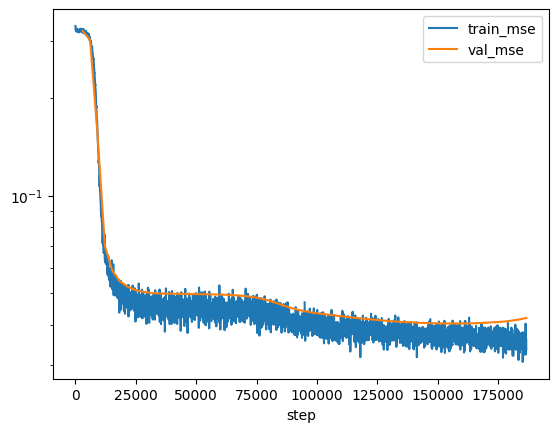

In [25]:
if TEST:
    ax = metric_df.plot(x="step", y=["train_mse"], logy=True)
    metric_df.dropna(subset="val_mse").plot(x="step", y=["val_mse"], logy=True, ax=ax)